In [77]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import random
import re
from scipy.stats import ks_2samp
from random import sample 


In [3]:
def umap_distance(rv_1, rv_2, df_umap):
    x1 = df_umap[df_umap.Rv_ID == rv_1].u1.values[0]
    y1 = df_umap[df_umap.Rv_ID == rv_1].u2.values[0]
    x2 = df_umap[df_umap.Rv_ID == rv_2].u1.values[0]
    y2 = df_umap[df_umap.Rv_ID == rv_2].u2.values[0]
    return np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )

In [4]:
def shuffle_genes(df_not_shuffled):
    ### shuffling of genes with respect to UMAP coordinates:
    cols_genes = df_not_shuffled.columns[:4]
    cols_umap = df_not_shuffled.columns[4:]

    df_genes = df_not_shuffled[cols_genes].copy()
    df_umap = df_not_shuffled[cols_umap].copy()

    df_genes_shuffle = df_genes.reindex(np.random.permutation(df_genes.index)).reset_index(drop = True)
    df_shuffle = pd.concat([df_genes_shuffle, df_umap], axis=1)
    
    return df_shuffle

In [6]:
df_lfc = pd.read_csv('../../data/tests/df_umap_lfc.csv')
df_lfc.head(2)

,Rv_ID,gene_name,Annotation,func_tuberculist,COG,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,...,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45,zhang_wt_mouse_d10_vs_zhang_input_library,zhang_wt_mouse_d45_vs_zhang_input_library,u1,u2,u3
0,Rv0001,dnaA,4.0,information pathways,L,-0.41,0.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.734426,18.285404,6.110508
1,Rv0002,dnaN,4.0,information pathways,L,3.28,2.38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.292060,18.294655,6.440992


In [4]:
df = pd.read_csv('../../data/tests/df_umap.csv')
df.head(2)

,Rv_ID,gene_name,func_tuberculist,COG,u1,u2,u3
0,Rv0003,recF,information pathways,L,-3.392495,-0.767878,21.184734
1,Rv0007,-,cell wall and cell processes,S,3.322289,-4.584758,13.685445


In [7]:
rv_1 = 'Rv0003'
rv_2 = 'Rv0007'
umap_distance(rv_1, rv_2, df_lfc)

0.8452685172535406

In [9]:
list_rv_id = df_lfc.Rv_ID.to_list()
list_rv_id = [rv for rv in list_rv_id if 'Rvnr' not in rv]
list_int_rv_id = [int(re.split( 'c|A|B|D|X' , rv.split('Rv')[1] )[0]) for rv in list_rv_id]

In [94]:
window_size = 1

In [95]:
list_pairs = [(list_rv_id[i], list_rv_id[j]) for i in range(len(list_rv_id)) for j in range(i+1,len(list_rv_id)) 
 if np.abs(list_int_rv_id[i] - list_int_rv_id[j]) <= window_size]

In [98]:
len( list_pairs )

4353

In [96]:
list_dist = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist.append(umap_distance( rv_pair[0], rv_pair[1], df_lfc))

100%|██████████| 4353/4353 [00:15<00:00, 283.24it/s]


Distances between random pairs of genes: 

In [99]:
# num_iter = len(list_pairs)
num_iter = len( list_pairs )
list_dist_rand = []
for i in range(num_iter):
    rvid_pair = random.sample(list_rv_id, 2)
    list_dist_rand.append(umap_distance( rvid_pair[0], rvid_pair[1], df_lfc))

In [100]:
len( list_dist_rand )

4353

cumulative distribution:

In [101]:
xrange = np.arange(0, 20, 0.01)
cum_list_dist = []
cum_list_dist_rand = []

for x in xrange:
    num_d = [d for d in list_dist if d <= x]
    norm_d = len(num_d) / len(list_dist)
    cum_list_dist.append(norm_d)
    
    num_d_rand = [d for d in list_dist_rand if d <= x]
    norm_d_rand = len(num_d_rand) / len(list_dist_rand)
    cum_list_dist_rand.append(norm_d_rand)

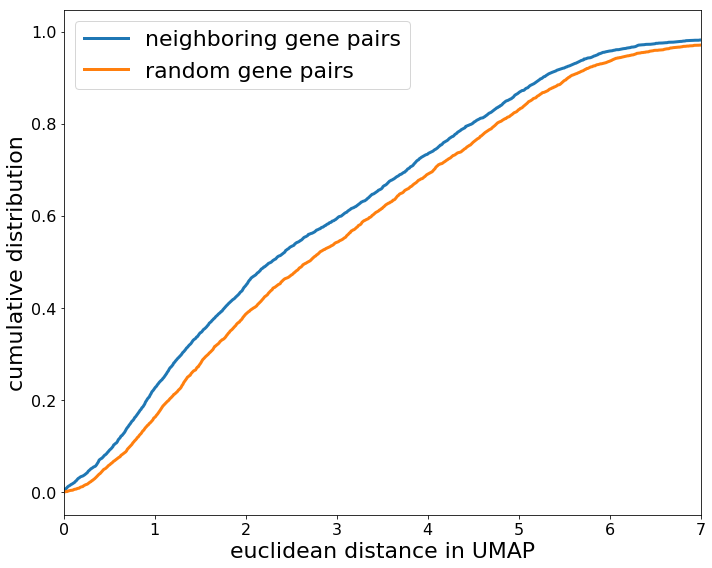

In [102]:
plt.figure(figsize = (10,8))
plt.plot(xrange, cum_list_dist, lw = 3)
plt.plot(xrange, cum_list_dist_rand, lw = 3)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('cumulative distribution', fontsize = 22)
plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)
lgn=plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlim(0, 7)
plt.tight_layout()
# plt.savefig('../../figures/pairwise_distances/umap_vs_genome_cumulative_w3.png', dpi=300)

In [103]:
ks_2samp(list_dist, list_dist_rand)

KstestResult(statistic=0.07213416034918448, pvalue=2.8627889783439936e-10)

In [115]:
size = 2000
list_dist_subsamp = sample( list_dist, size )
ks_2samp(list_dist, list_dist_subsamp)

KstestResult(statistic=0.025143004824259133, pvalue=0.34447931558069567)

histogram:

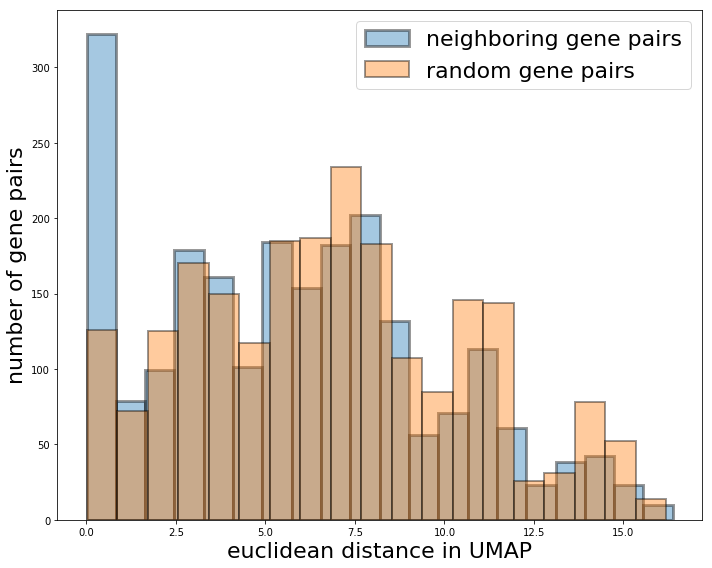

In [44]:
plt.figure(figsize = (10,8))
sns.distplot(list_dist, kde = False,  hist_kws=dict(edgecolor="k", linewidth=3))
sns.distplot(list_dist_rand, kde = False,  hist_kws=dict(edgecolor="k", linewidth=2))

plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('number of gene pairs', fontsize = 22)

plt.tight_layout()
# plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3.png', dpi=300)

In [24]:
ks_2samp(list_dist, list_dist_rand)

Ks_2sampResult(statistic=0.11917562724014337, pvalue=3.190900997267313e-14)

### Compare to shuffled data:

In [29]:
df_shuffled = shuffle_genes(df)

In [30]:
list_dist_shuffled = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist_shuffled.append(umap_distance( rv_pair[0], rv_pair[1], df_shuffled))

100%|██████████| 2232/2232 [00:05<00:00, 414.03it/s]


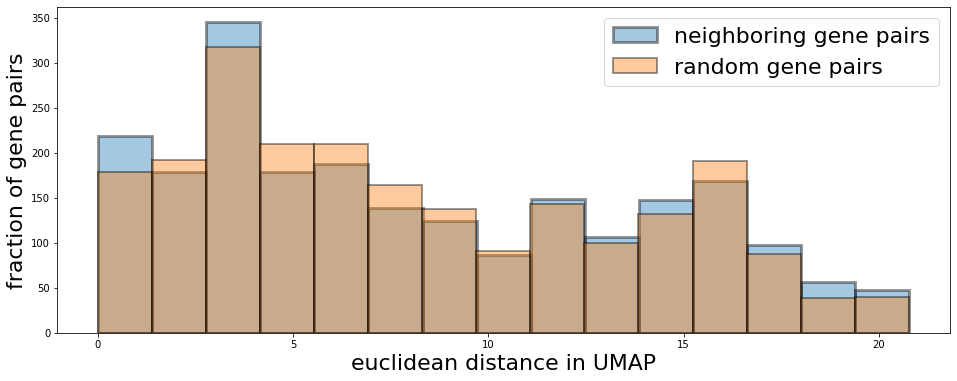

In [31]:
plt.figure(figsize = (16,6))
sns.distplot(list_dist_shuffled, kde = False,  hist_kws=dict(edgecolor="k", linewidth=3))
sns.distplot(list_dist_rand, kde = False,  hist_kws=dict(edgecolor="k", linewidth=2))
plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('fraction of gene pairs', fontsize = 22)
plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3_RAND.png', dpi=300)

In [32]:
ks_2samp(list_dist_shuffled, list_dist_rand)

Ks_2sampResult(statistic=0.025537634408602152, pvalue=0.46066938637808946)